In [5]:
'''
#Python3: BotsDataDownload.py
@authors: jubinsoni
#Submission for DataScience Incubator: Project
Dependencies: Tweepy, Pandas, Numpy
#Description: Using Twitter REST API data is downloaded, bots and nonbots are labeled and results saved into a csv.
'''
""

''

### First I have collected the data using Twitter API

In [ ]:
import tweepy
import os,sys, csv, time
import pandas as pd
import numpy as np

def createOutput(data, isbot):
    header = ['id', 'id_str', 'screen_name', 'location', 'description', 'url',
                'followers_count', 'friends_count', 'listed_count', 'created_at',
                'favourites_count', 'verified', 'statuses_count', 'lang', 'status',
                'default_profile','default_profile_image', 'has_extended_profile',
                'name']
    d = {}
    for key in header:
        if key not in data.keys():
            d[key] = ""
        elif key == 'status':
            d[key] = str(data[key])
        else:
            d[key] = data[key]

    df = pd.DataFrame(d, columns= header, index=np.arange(1))
    df['bot'] = isbot
    return df

def get_bots_list():
    bots_list = []
    for bots in tweepy.Cursor(api.list_members, '01101O10', 'bot-list').items():
        bots_list.append (bots._json['screen_name'])
    return bots_list[:50]

def real_users_list():
    real_users = []
    for users in tweepy.Cursor(api.list_members, 'Scobleizer', 'most-influential-in-tech').items():
        real_users.append (users._json['screen_name'])
    return real_users[:50]

def get_user_list():
    user_list = get_bots_list() + real_users_list()
    filename = 'bots_nonbots_output.csv'
    return user_list, filename
    print ("Gathering real-time data Using Twitter API.")

In [ ]:
start=time.time()
#Twitter credentials
consumer_key='25SjEQNdimGLs9BNcAfbJW3dA'
consumer_secret='RTt7e2m4iWwbXUUHyH4Vn7YRm6jpoQmm4m8RhedqohQBNbyYLU'
access_key = '755246834826838016-GPchEozsoRFTm10LbSbUKyG2NlIoLOR'
access_secret = 'x0LXflU8vJFojsXfgumxLNlh8TEMUCUpqkK5fuH98UY6o'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_key,access_secret)
api = tweepy.API(auth)

user_list, filename = get_user_list()

df = pd.DataFrame()
for i,users in enumerate(user_list, start=1):
    isbot=0
    if(i<=50):
        isbot=1
    data = api.get_user(users)._json
    data_df1 = createOutput(data, isbot)
    df = pd.concat([data_df1, df], axis= 0, ignore_index = True)

df.to_csv(filename, encoding='utf-8')
print ("All records are saved to csv. \nDuration: "+str(time.time()-start)+" seconds.")

### Analyzing important features (Pre-processing)

In [20]:
import os,sys, csv, time
import pandas as pd
import numpy as np

#Due to data download limit I already had downloaded the data at below location

filepath = 'https://raw.githubusercontent.com/jubins/ML-TwitterBotDetection/master/Project/data/'
bots = pd.read_csv(filepath+'bots_data.csv')
nonbots = pd.read_csv(filepath+'nonbots_data.csv')

#### Plot 1: Followers vs Following Count

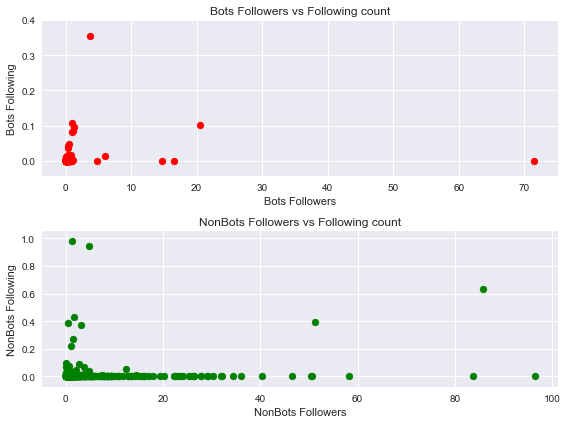

In [78]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(8,6))
plt.subplot(2, 1, 1)
bots_followers = bots.followers_count/100000
bots_friends = bots.friends_count/1000000
plt.scatter(bots_followers, bots_friends, color='red')
plt.xlabel("Bots Followers")
plt.ylabel("Bots Following")
plt.title("Bots Followers vs Following count")

plt.subplot(2, 1, 2)
nonbots_followers = nonbots.followers_count/1000000
nonbots_friends = nonbots.friends_count/1000000
plt.scatter(nonbots_followers, nonbots_friends, color='green')
plt.xlabel("NonBots Followers")
plt.ylabel("NonBots Following")
plt.title("NonBots Followers vs Following count")

plt.tight_layout()
plt.show()

#### Plot 2: Frequecy of appearance of Bots vs NonBots in ScreenName

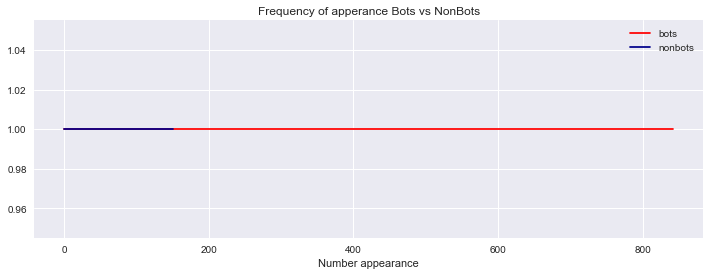

In [108]:
x = bots[(bots.screen_name.str.contains("bot", case=False)==True)].screen_name_binary[:150]
y = nonbots[(nonbots.screen_name.str.contains("bot", case=False)==False)].screen_name_binary[:150]

plt.figure(figsize=(12,4))
plt.plot(x, color='red', label='bots')
plt.plot(y, color='darkblue', label='nonbots')
plt.xlabel('Frequency of bots')
plt.xlabel('Number appearance')
plt.legend(loc='upper right')
plt.title('Frequency of apperance Bots vs NonBots')

In [91]:
def vectorize_bots(bots, condition):
    bots['screen_name_binary'] = (bots.screen_name.str.contains("bot", case=False)==True)
    bots['description_binary'] = (bots.description.str.contains("bot", case=False)==True)
    bots['location_binary'] = (bots.location.isnull())
    bots['verified_binary'] = (bots.verified==False)
    return bots

def vectorize_nonbots(nonbots, condition):
    nonbots['screen_name_binary'] = (nonbots.screen_name.str.contains("bot", case=False)==False)
    nonbots['description_binary'] = (nonbots.description.str.contains("bot", case=False)==False)
    nonbots['location_binary'] = (nonbots.location.isnull()==False)
    nonbots['verified_binary'] = (nonbots.verified==True)
    return nonbots


#Creating Bots identifying condition
#bots[bots.listedcount>10000]
condition = (bots.screen_name.str.contains("bot", case=False)==True)|(bots.description.str.contains("bot", case=False)==True)|(bots.location.isnull())|(bots.verified==False)
bots = vectorize_bots(bots, condition)
print("Bots shape: {0}".format(bots.shape))

#Creating NonBots identifying condition
condition = (nonbots.screen_name.str.contains("bot", case=False)==False)| (nonbots.description.str.contains("bot", case=False)==False) |(nonbots.location.isnull()==False)|(nonbots.verified==True)
nonbots = vectorize_nonbots(nonbots, condition)
print("Nonbots shape: {0}".format(nonbots.shape))

Bots shape: (1056, 24)
Nonbots shape: (1176, 24)


In [92]:
#Joining Bots and NonBots dataframes
df = pd.concat([bots, nonbots])
print("DataFrames created.")

DataFrames created.


In [93]:
#Splitting data randombly into train_df and test_df
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2)
print("Randomly splitting the dataset into training and test, and training classifiers.\n")

Randomly splitting the dataset into training and test, and training classifiers.



### Using Decision Tree Classifier

In [94]:
#Using Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

clf = DecisionTreeClassifier(criterion='entropy')

#80%
X_train = train_df[['screen_name_binary', 'description_binary', 'location_binary', 'verified_binary']] #train_data
y_train = train_df['bot'] #train_target

#20%
X_test = test_df[['screen_name_binary', 'description_binary', 'location_binary', 'verified_binary']] #test_Data
y_test = test_df['bot'] #test_target

#Training on decision tree classifier
model = clf.fit(X_train, y_train)

#Predicting on test data
predicted = model.predict(X_test)

#Checking accuracy
print("Decision Tree Classifier Accuracy: {0}".format(accuracy_score(y_test, predicted)))

Decision Tree Classifier Accuracy: 0.9172259507829977
